In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from udf import score_udf, score, agg_features
import pandas as pd


In [2]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_train[:10]

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341
5,33172,11,11,17.941
6,33172,12,11,17.726
7,33172,13,18,47.397
8,33172,13,1,220.009
9,33172,13,11,9.067


In [3]:
train_target = pd.read_csv('data/train_target.csv', index_col='client_id')
train_target[:5].reset_index()

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


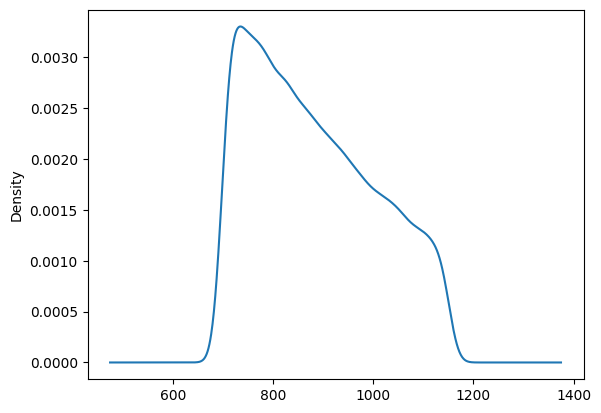

In [4]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_train.groupby('client_id').client_id.count().plot.kde();

In [6]:
transactions_train = pd.read_csv('data/transactions_train.csv')
transactions_test = pd.read_csv('data/transactions_test.csv')
train_target = pd.read_csv('data/train_target.csv', index_col='client_id')
transactions = pd.concat([transactions_train, transactions_test])
agg = agg_features(transactions)

train_df = agg[agg.index.isin(train_target.index)]
test_df = agg[~agg.index.isin(train_target.index)]

train_df.to_csv('data/agg_train.csv')
test_df.to_csv('data/agg_test.csv')

In [7]:
train_df = pd.read_csv('data/agg_train.csv', index_col='client_id')
train_df[:5].T

client_id,4,6,7,10,11
sum,28404.121000,15720.739000,53630.036000,34419.365000,26789.404000
mean,39.450168,21.535259,69.379089,48.752642,32.991877
std,73.511624,26.200397,253.261383,63.191701,107.395139
min,0.043000,0.045000,0.043000,0.045000,0.388000
max,1341.802000,315.781000,4505.971000,654.893000,2105.058000
...,...,...,...,...,...
small_group_std_195,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_196,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_197,0.000000,0.000000,0.000000,0.000000,0.000000
small_group_std_198,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

train_df = pd.read_csv('data/agg_train.csv').sort_index()
train_target = pd.read_csv('data/train_target.csv', index_col='client_id').sort_index()

m = RandomForestClassifier(n_estimators=100, oob_score=True).fit(train_df, train_target)
dump(m, 'data/rfm.dump')
m.oob_score_

/Users/dmitri/gdrive/code/pyspark-score-tutorial/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5746666666666667

In [9]:
from pyspark.sql import SparkSession

ss = SparkSession.builder.master('local').config(
    'spark.executor.instances', '1'
).getOrCreate()

ss.sparkContext

25/03/17 01:13:44 WARN Utils: Your hostname, macbook-dllllb.local resolves to a loopback address: 127.0.0.1; using 192.168.1.9 instead (on interface en0)
25/03/17 01:13:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/17 01:13:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local appName=pyspark-shell>

In [10]:
from joblib import load
m = load('data/rfm.dump')

df = ss.read.csv('data/agg_test.csv', header=True)
class_names=[f'age_group{i}' for i in range(4)]

In [11]:
%%time

scores = score(ss.sparkContext, df, m, cols_to_save=['client_id'], target_class_names=class_names).cache()
scores.count()

CPU times: user 31.3 ms, sys: 171 ms, total: 202 ms
Wall time: 19.7 s


20000

In [12]:
scores.show()

+----------+----------+----------+----------+---------+
|age_group0|age_group1|age_group2|age_group3|client_id|
+----------+----------+----------+----------+---------+
|      0.12|      0.02|      0.85|      0.01|        0|
|      0.15|       0.5|      0.08|      0.27|        1|
|      0.26|      0.24|      0.16|      0.34|        2|
|       0.3|      0.11|      0.07|      0.52|        3|
|      0.28|      0.21|      0.27|      0.24|        5|
|      0.27|      0.29|      0.07|      0.37|        8|
|       0.3|      0.09|      0.47|      0.14|        9|
|      0.06|      0.82|      0.03|      0.09|       15|
|      0.28|      0.24|      0.22|      0.26|       16|
|      0.35|      0.17|      0.19|      0.29|       21|
|       0.3|      0.21|      0.03|      0.46|       24|
|       0.2|      0.38|      0.05|      0.37|       30|
|      0.23|      0.35|      0.07|      0.35|       35|
|      0.13|      0.02|       0.8|      0.05|       41|
|      0.02|      0.82|       0.0|      0.16|   

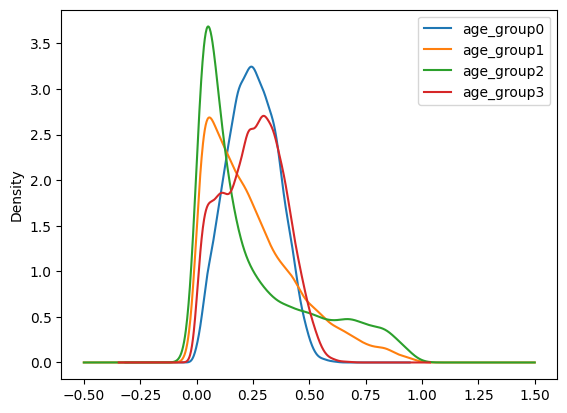

In [13]:
s_pdf = scores.toPandas()
s_pdf.plot.kde();

In [14]:
%%time

scores = score_udf(df, m, target_class_names=class_names, cols_to_save=['client_id']).cache()
scores.count()

25/03/17 01:14:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 41.8 ms, sys: 115 ms, total: 156 ms
Wall time: 6.53 s


20000

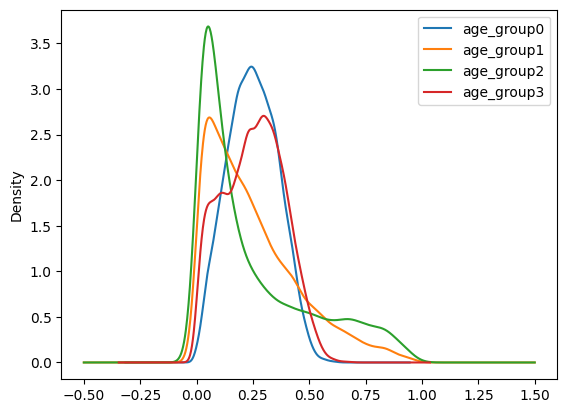

In [15]:
s_pdf = scores.toPandas()
s_pdf.plot.kde();